In [60]:
import sys
sys.path.append('../src/helpers')
from im2col import im2col
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [61]:
class Conv2D:
    def __init__(self, num_filters, size=(3,3), stride=1, padding=1):
        self.num_filters = num_filters
        self.kernel_size = size
        self.stride = stride
        self.padding = padding
        self.kernels = []
        for i in range(self.num_filters):
            self.kernels.append(torch.randn(size[0], size[1]))
    
    def im2col(self, x, kernel_shape):
        img_to_pad = transforms.Compose([
                 transforms.ToPILImage(),
                 transforms.Pad(padding=self.padding, fill=0, padding_mode="constant"),
                 transforms.ToTensor(),
             ])
        x = img_to_pad(x)
        x = x[0]
        rows = []
        for row in range(0,x.shape[0]-2,self.stride):
            for col in range(0,x.shape[1]-2,self.stride):
                window = x[row:row+kernel_shape, col:col+kernel_shape]
                rows.append(window.flatten())
        rows = torch.stack(rows)
        result = torch.tensor(rows).t()
        return result
    
    def forward(self, X):
        cols = self.im2col(X, self.kernel_size[0])
        convolved_arrs = []
        for kernel in self.kernels:
            convolved = torch.matmul(kernel.flatten(), cols)
            convolved_arrs.append(convolved)
        convolved_arrs = torch.stack(convolved_arrs)
        convolved_arrs = torch.tensor(convolved_arrs)
        shapes = convolved_arrs[0].shape[0]
        shape = torch.tensor(shapes,dtype=torch.float32)
        h, w = int(torch.sqrt(shape)), int(torch.sqrt(shape))
        outs = []
        for convolved in convolved_arrs:
            out = convolved.view(h,w,1)
            outs.append(out)
        outs = torch.stack(outs)
        outs = torch.tensor(outs)
        cache = (X, self.kernels, self.stride, self.padding, cols)
        return outs, cache
    
    def backward(self, dZ):
        pass

In [62]:
path = "../imgs/kitten.jpg"

In [63]:
kitten = cv2.imread(path,0)

In [64]:
res = cv2.resize(kitten, dsize=(50, 50), interpolation=cv2.INTER_CUBIC)

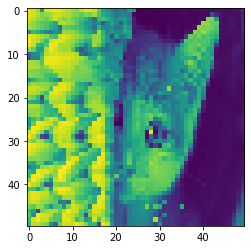

In [65]:
plt.imshow(res)

In [66]:
conv_layer = Conv2D(2,stride=2)
result, cache = conv_layer.forward(res)

c:\users\nurbe\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\nurbe\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\nurbe\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


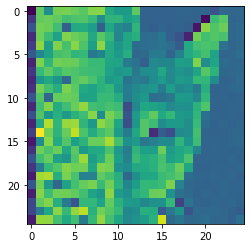

In [67]:
plt.imshow(result[0].view(25,25))